# Import libraries

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For drive access
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load train data csv file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_3_species_metadata_32000sr_w_location.csv')

df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent
0,eaywag1,eaywag1/XC118267.ogg,call,eaywag1/XC118267.npy,good,11.885719,SN,AFRICA
1,eaywag1,eaywag1/XC133264.ogg,call,eaywag1/XC133264.npy,good,5.459594,RU,EUROPE
2,eaywag1,eaywag1/XC133266.ogg,song,eaywag1/XC133266.npy,good,42.971438,RU,EUROPE
3,eaywag1,eaywag1/XC134075.ogg,call,eaywag1/XC134075.npy,good,6.347750,HU,EUROPE
4,eaywag1,eaywag1/XC138503.ogg,call,eaywag1/XC138503.npy,good,69.746938,DK,EUROPE


# Inspect the dataset

In [ ]:
df['primary_label'].value_counts()

comsan     349
eaywag1    348
barswa     347
Name: primary_label, dtype: int64

In [ ]:
df['continent'].value_counts()

EUROPE      887
ASIA         72
AMERICAS     54
UNKNOWN      16
AFRICA       15
Name: continent, dtype: int64

In [ ]:
df.groupby('primary_label').sum('duration_secs_32000')

,duration_secs_32000
primary_label,
barswa,13076.454906
comsan,10311.578656
eaywag1,11624.485844


**there is a slight imbalance in the total duration among species, we will downsample barswa and eaywag1 to create balanced classes**

In [ ]:
# shuffle the dataset before down_sampling
df = df.sample(frac=1)

In [ ]:
df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent
166,eaywag1,eaywag1/XC584625.ogg,call,eaywag1/XC584625.npy,good,116.375000,EE,EUROPE
572,comsan,comsan/XC646457.ogg,call,comsan/XC646457.npy,good,28.003000,FI,EUROPE
384,comsan,comsan/XC342917.ogg,call,comsan/XC342917.npy,good,16.901219,FI,EUROPE
998,barswa,barswa/XC671664.ogg,call,barswa/XC671664.npy,good,10.109000,NL,EUROPE
1004,barswa,barswa/XC673595.ogg,call,barswa/XC673595.npy,good,38.765719,AT,EUROPE


In [ ]:
down_sampled = pd.DataFrame()

for species in df['primary_label'].unique():
  species_df = df[df['primary_label'] == species].copy()
  duration = 0

  while duration <= 10300:
    sample = species_df.sample(n=1, replace=False)
    species_df.drop(sample.index, inplace=True)
    duration = duration + sample['duration_secs_32000'].item()
    down_sampled = pd.concat([down_sampled, sample])

In [ ]:
down_sampled['primary_label'].value_counts()

comsan     349
eaywag1    309
barswa     282
Name: primary_label, dtype: int64

In [ ]:
down_sampled.groupby('primary_label').sum('duration_secs_32000')

,duration_secs_32000
primary_label,
barswa,10374.747812
comsan,10311.578656
eaywag1,10318.291125


**There isn't a huge class imbalance in the audio quality rating among the different classes so we will just leave it as is.**

In [ ]:
len(down_sampled[(down_sampled['primary_label'] == 'barswa') & (down_sampled['rating'] == 'good')])/len(down_sampled[down_sampled['primary_label'] == 'barswa'])

0.9113475177304965

In [ ]:
len(down_sampled[(down_sampled['primary_label'] == 'comsan') & (down_sampled['rating'] == 'good')])/len(down_sampled[down_sampled['primary_label'] == 'comsan'])

0.8022922636103151

In [ ]:
len(down_sampled[(down_sampled['primary_label'] == 'eaywag1') & (down_sampled['rating'] == 'good')])/len(down_sampled[down_sampled['primary_label'] == 'eaywag1'])

0.8252427184466019

Take a look at the locations by species to see if there is any patterns that could be useful in training

In [ ]:
down_sampled['continent'].value_counts()

EUROPE      798
ASIA         68
AMERICAS     45
UNKNOWN      15
AFRICA       14
Name: continent, dtype: int64

In [ ]:
def location_plots(dataframe):
  grouped_country_df = dataframe.groupby(['primary_label', 'country']).size().reset_index(name='Count')
  grouped_continent_df = dataframe.groupby(['primary_label', 'continent']).size().reset_index(name='Count')

  # Pivot the DataFrame to have 'primary_label' as rows, 'country' or 'continent' as columns, and 'Count' as values
  pivot_country_df = grouped_country_df.pivot(index='primary_label', columns='country', values='Count')
  pivot_continent_df = grouped_continent_df.pivot(index='primary_label', columns='continent', values='Count')

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

  sns.heatmap(pivot_country_df, cmap='YlGnBu', annot=True, fmt='g', cbar=True, ax=axes[0])
  axes[0].set_xlabel('country Code')
  axes[0].set_ylabel('species')
  axes[0].set_title('number of samples by species and country')

  sns.heatmap(pivot_continent_df, cmap='YlGnBu', annot=True, fmt='g', cbar=True, ax=axes[1])
  axes[1].set_xlabel('continent')
  axes[1].set_ylabel('species')
  axes[1].set_title('number of samples by species and continent')

  fig.tight_layout(pad=3.0)

  plt.show()

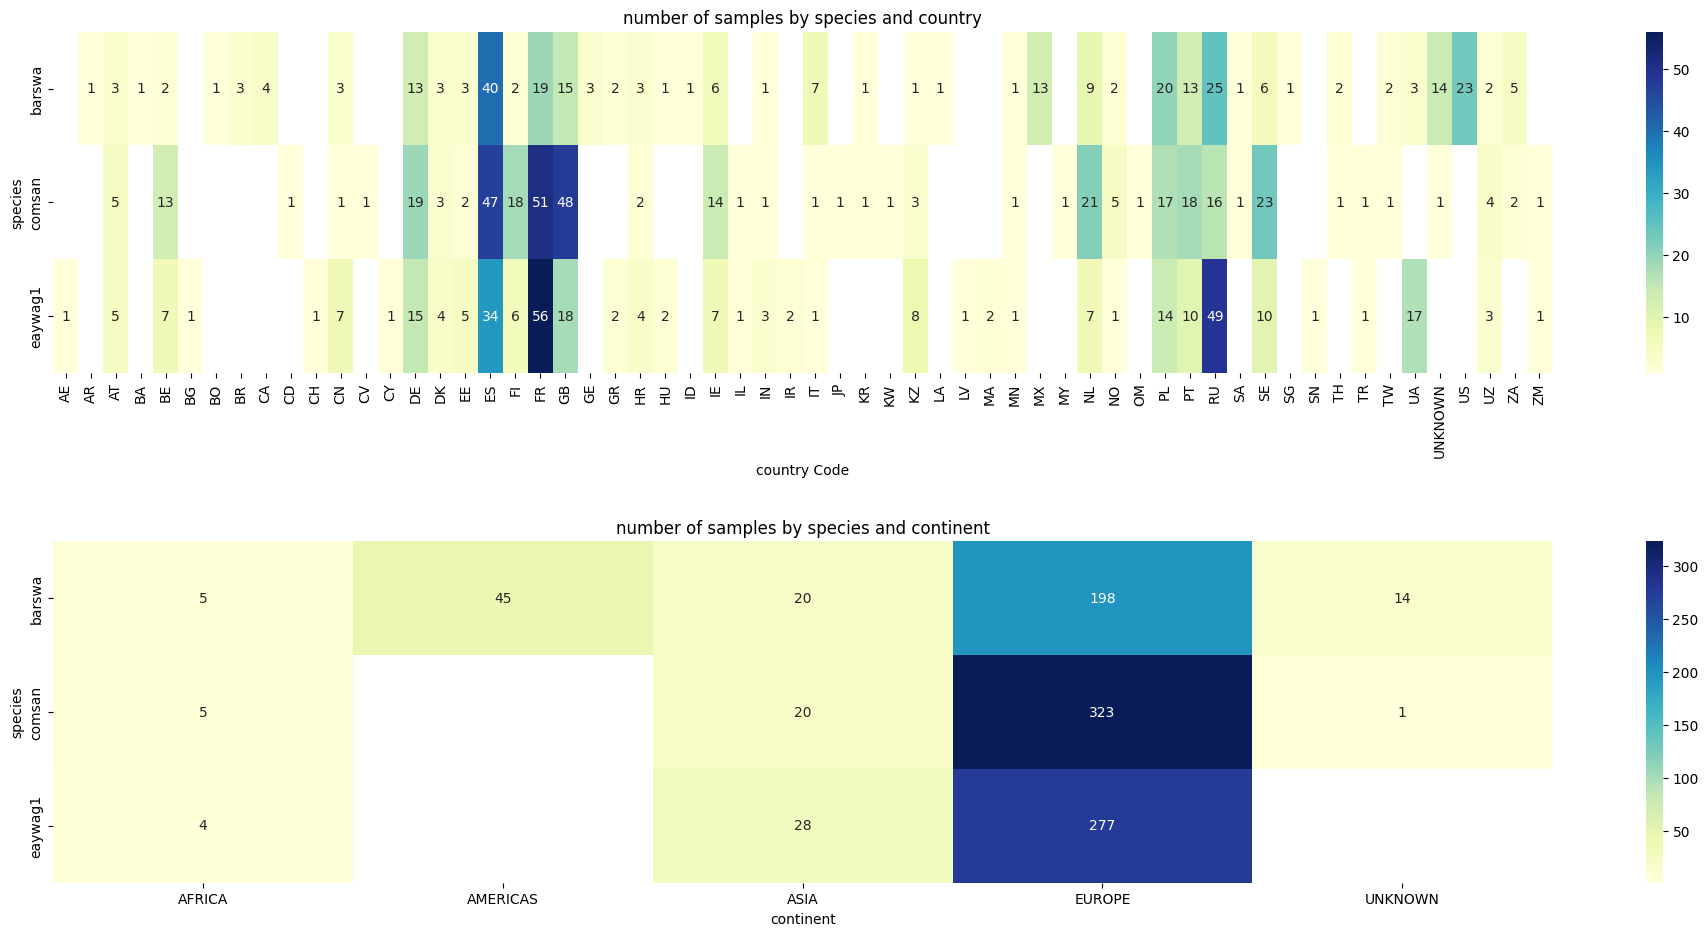

In [ ]:
location_plots(down_sampled)
# barswa is the only bird in Americas, that could be information that we can use when we build our models

# Split the samples to train vs validation

In [ ]:
del df

### To get training data

In [ ]:
training_samples = pd.DataFrame()

for species in down_sampled['primary_label'].unique():
  species_df = down_sampled[down_sampled['primary_label'] == species].copy()
  n_train = int(len(species_df)*0.7)

  samples = species_df.sample(n=n_train, replace=False)
  training_samples = pd.concat([training_samples, samples])

In [ ]:
training_samples.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent
313,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE
273,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE
317,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE
252,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE
284,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE


In [ ]:
training_samples[['primary_label', 'duration_secs_32000']].groupby('primary_label').sum('duration_secs_32000').reset_index()

,primary_label,duration_secs_32000
0,barswa,7418.617906
1,comsan,7488.164156
2,eaywag1,7235.116813


In [ ]:
training_samples['primary_label'].value_counts()

comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64

In [ ]:
len(training_samples)

657

In [ ]:
# to confirm there are no duplicates being sampled
len(training_samples) == training_samples['filename_npy'].nunique()

True

### To get validation data

In [ ]:
validation_samples = down_sampled.drop(training_samples.index)

In [ ]:
validation_samples.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent
16,eaywag1,eaywag1/XC182483.ogg,call,eaywag1/XC182483.npy,good,21.072,KZ,ASIA
276,eaywag1,eaywag1/XC675723.ogg,call,eaywag1/XC675723.npy,good,83.330,RU,EUROPE
178,eaywag1,eaywag1/XC589278.ogg,call,eaywag1/XC589278.npy,good,13.320,FR,EUROPE
106,eaywag1,eaywag1/XC467878.ogg,call,eaywag1/XC467878.npy,poor,6.582,BE,EUROPE
192,eaywag1,eaywag1/XC634278.ogg,call,eaywag1/XC634278.npy,good,26.616,PT,EUROPE


In [ ]:
validation_samples[['primary_label', 'duration_secs_32000']].groupby('primary_label').sum('duration_secs_32000').reset_index()

,primary_label,duration_secs_32000
0,barswa,2956.129906
1,comsan,2823.414500
2,eaywag1,3083.174312


In [ ]:
validation_samples['primary_label'].value_counts()

comsan     105
eaywag1     93
barswa      85
Name: primary_label, dtype: int64

In [ ]:
# to confirm there are no duplicates being sampled
len(validation_samples) == validation_samples['filename_npy'].nunique()

True

In [ ]:
# to confirm data in validation are not in training
is_present = validation_samples.isin(training_samples).any().any()

if not is_present:
    print("OK")
else:
    print("NOT OK")

OK


# visualize the distribution & location of species in training set

In [ ]:
def distribution_plots(dataframe):
  bins = bins = np.arange(4) - 0.5
  duration_sum_by_species = dataframe[['primary_label', 'duration_secs_32000']].groupby('primary_label').sum('duration_secs_32000').reset_index()

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

  axes[0][0].hist(dataframe['primary_label'], rwidth=0.7, bins=bins)
  axes[0][0].axhline(y=dataframe['primary_label'].value_counts().min(), color='r', label=dataframe['primary_label'].value_counts().min())
  axes[0][0].legend()
  axes[0][0].set_xlabel('species')
  axes[0][0].set_ylabel('number of samples')
  axes[0][0].set_title('number of samples by species')


  axes[0][1].bar(duration_sum_by_species['primary_label'], duration_sum_by_species['duration_secs_32000'])
  axes[0][1].axhline(y=duration_sum_by_species.duration_secs_32000.min(), color='r', label=f'{round(duration_sum_by_species.duration_secs_32000.min()/60,2)} mins')
  axes[0][1].legend()
  axes[0][1].set_xlabel('species')
  axes[0][1].set_ylabel('total duration')
  axes[0][1].set_title('total duration by species')


  axes[1][0].hist([dataframe['primary_label'][dataframe['type']=='blank'],
            dataframe['primary_label'][dataframe['type']=='call'],
            dataframe['primary_label'][dataframe['type']=='song'],
            dataframe['primary_label'][dataframe['type']=='both']],
            label=['blank', 'call', 'song', 'both'], rwidth=0.7, bins=bins)
  axes[1][0].legend()
  axes[1][0].set_xlabel('species')
  axes[1][0].set_ylabel('number of samples')
  axes[1][0].set_title('number of samples by species by call type')


  axes[1][1].hist([dataframe['primary_label'][dataframe['rating']=='good'],
            dataframe['primary_label'][dataframe['rating']=='poor']],
            label=['good', 'poor'], rwidth=0.7, bins=bins)
  axes[1][1].legend()
  axes[1][1].set_xlabel('species')
  axes[1][1].set_ylabel('number of samples')
  axes[1][1].set_title('number of samples by species by audio quality')

  plt.show()

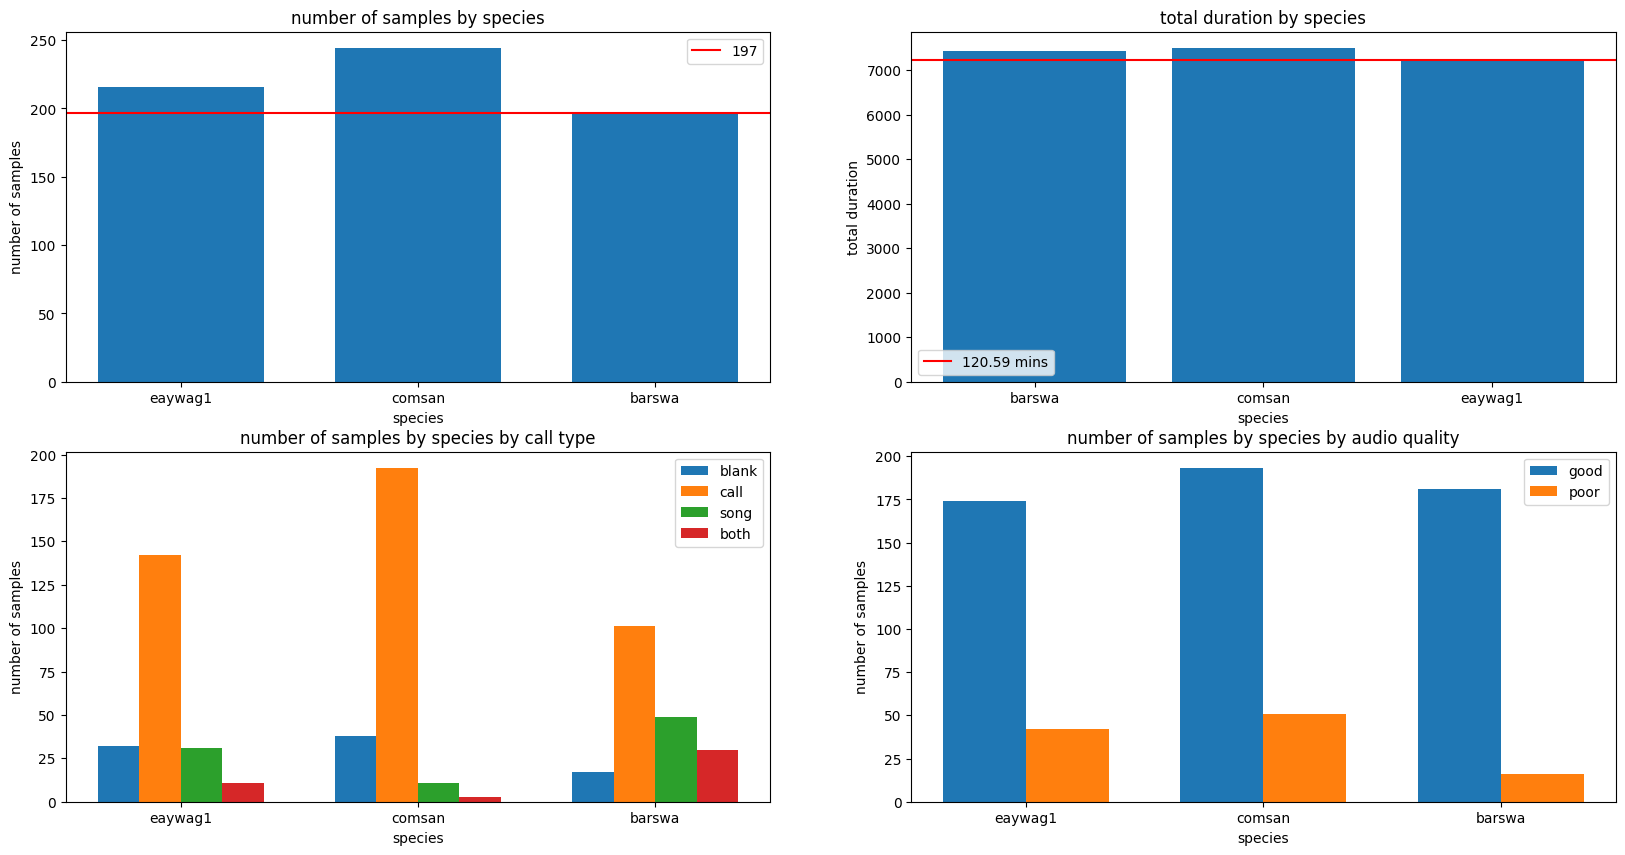

In [ ]:
distribution_plots(training_samples)

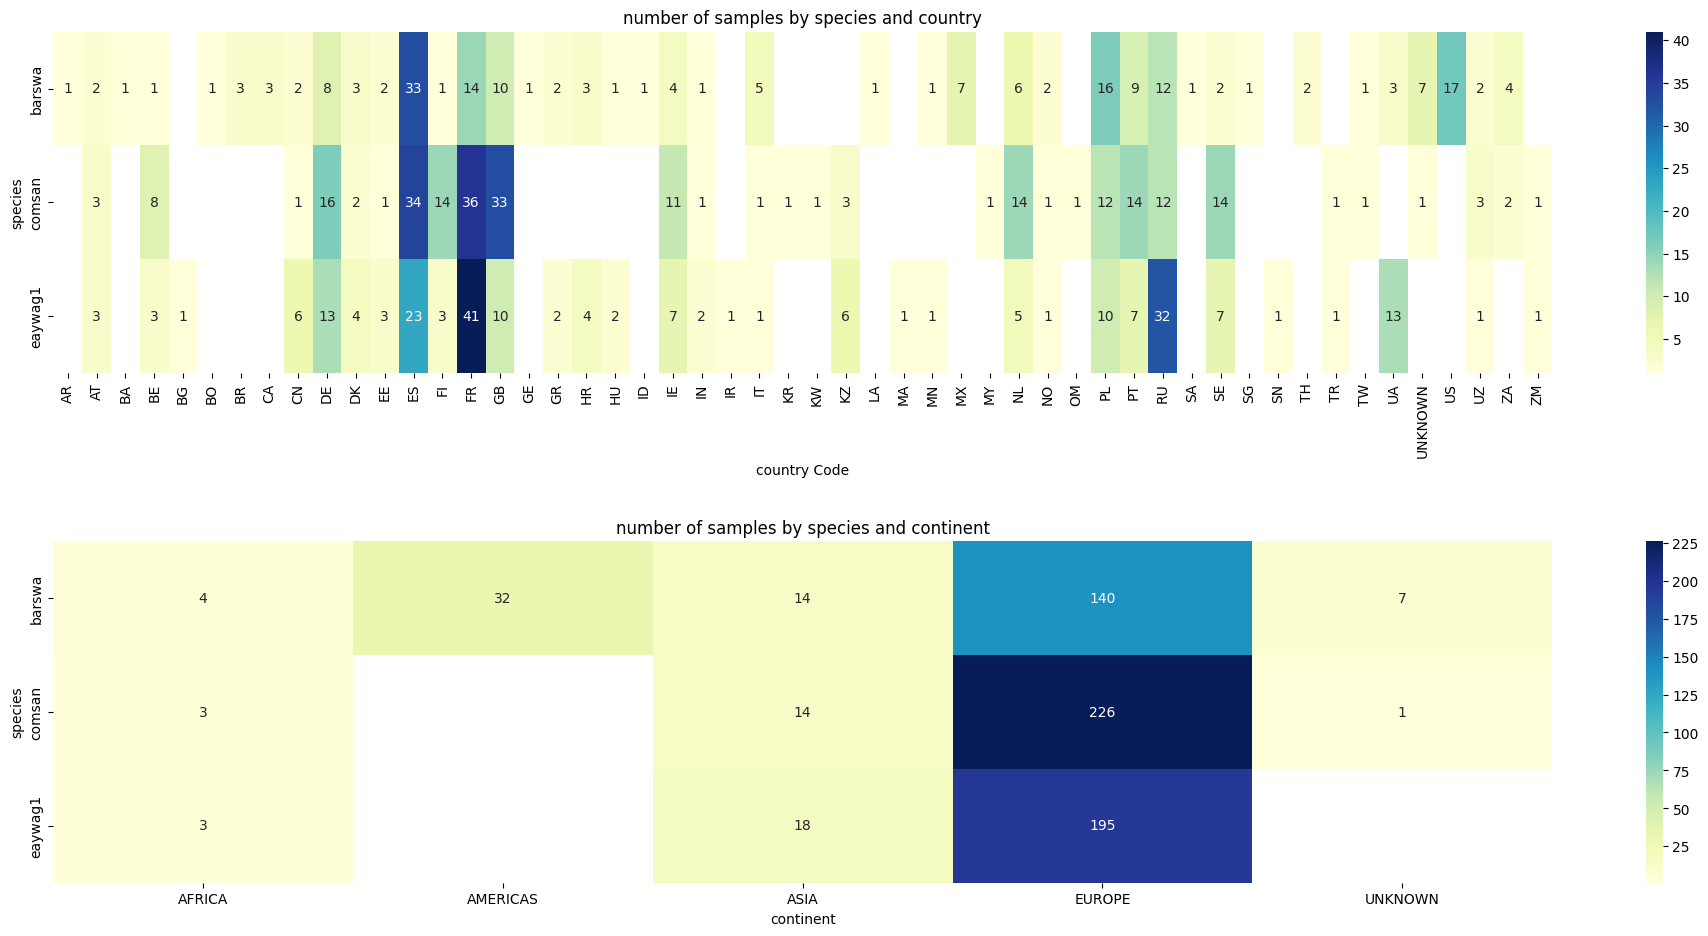

In [ ]:
location_plots(training_samples)

# save train/validation and test to separate csv

In [ ]:
training_samples['data'] = 'train'

In [ ]:
validation_samples['data'] = 'val'

In [ ]:
train_val_df = pd.concat([training_samples, validation_samples])
len(train_val_df)

940

In [ ]:
train_val_df.to_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_val.csv', index=False)